In [1]:
import numpy as np
import phoebe
import matplotlib.pyplot as plt
plt.style.use('science')
import matplotlib
matplotlib.rcParams['font.size'] = 8

In [2]:
lc_tess = np.loadtxt('data/photometry/tess_corrected.txt')
lc_tess[:,0] = lc_tess[:,0]+2457000
rv1_song = np.loadtxt('data/RV/SONG_LSD.txt')
rv1_song[:,0]=rv1_song[:,0]+2400000

In [3]:
b = phoebe.default_binary()
b.add_dataset('lc', times=lc_tess[:,0], fluxes=lc_tess[:,1], sigmas=lc_tess[:,2],
              compute_phases=np.linspace(-0.5,0.5,10000),
              passband='TESS:T')
b.add_dataset('rv', component='primary', times=rv1_song[:,0], rvs=rv1_song[:,1], sigmas=rv1_song[:,2])

<ParameterSet: 81 parameters | contexts: dataset, constraint, compute, figure>

In [4]:
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

In [5]:
b.flip_constraint('sma@primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {sma@primary@component} * ((1.000000 / {q@binary@component}) + 1.000000) (solar units) => 5.3 solRad>

In [7]:
b.import_solution('mcmc_phoebe2_solution.progress')

<ParameterSet: 22 parameters | qualifiers: adopt_distributions, distributions_convert, niters, adopt_parameters, samples, adopt_values, lnprob_cutoff, fitted_twigs, burnin, fitted_units, failed_samples, distributions_bins, thin, progress, autocorr_times, nlags, wrap_central_values, lnprobabilities, imported_job, fitted_uniqueids, nwalkers, acceptance_fractions>

In [8]:
b.adopt_solution(solution='mcmc_r2', adopt_values=True, 
                 adopt_distributions=True, distribution='mcmc_r2_dist')

<ParameterSet: 73 parameters | contexts: dataset, distribution, component, system>

In [9]:
b.add_server('remoteslurm', crimpl_name='terra',
             use_conda=True, 
             conda_env='phoebe-devel', nprocs=48, walltime=48, install_deps=False,
             server='terra_phoebe_compute')

<ParameterSet: 11 parameters | qualifiers: use_mpi, isolate_env, slurm_job_name, mail_type, install_deps, conda_env, crimpl_name, mail_user, use_conda, nprocs, walltime>

In [10]:
b.set_value('distortion_method', component='secondary', value='sphere')
b.set_value('ntriangles', component='secondary', value=1500)
b.set_value('ntriangles', component='primary', value=3000)

In [11]:
b.run_compute(compute='phoebe01', model='lcmodel',
              use_server='terra_phoebe_compute', overwrite=True)

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/angela/crimpl/crimpl-job-2021.06.29-13.21.51/*"
# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.06.29-13.21.51/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/angela/crimpl/crimpl-job-2021.06.29-13.21.51"
# crimpl: scp crimpl_submit_script.sh /Users/angela/Documents/WORK/PHOETTING/adra-paper/_aBbTwuUKDXrayPaYRsIAknuBOOvhFJ.py terra:/home/users/angela/crimpl/crimpl-job-2021.06.29-13.21.51/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo '_aBbTwuUKDXrayPaYRsIAknuBOOvhFJ.py' >> /home/users/angela/crimpl/crimpl-job-2021.06.29-13.21.51/crimpl-input-files.list"
# cri

<ParameterSet: 5 parameters | kinds: rv, lc>

In [12]:
times_obs = b.get_value('times', context='dataset', dataset='lc01')
times_model = b.get_value('times', context='model', model='lcmodel', dataset='lc01')

phases_obs = b.to_phase(times_obs)
phases_model = b.to_phase(times_model)

sobs = np.argsort(phases_obs)
smodel = np.argsort(phases_model)

fluxes_obs = b.get_value('fluxes', context='dataset', dataset='lc01')
fluxes_model = b.get_value('fluxes', context='model', model='lcmodel', dataset='lc01')

In [13]:
residuals = b.calculate_residuals(model='lcmodel', dataset='lc01')

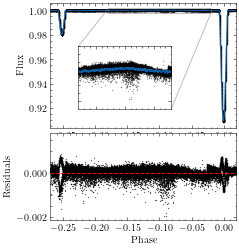

In [14]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=[10/3, 4], gridspec_kw={'height_ratios': [1, 0.7]})

axes[0].plot(phases_obs[sobs], fluxes_obs[sobs], '.k', alpha=0.6, ms=0.5, rasterized=True)
axes[0].plot(phases_model[smodel], fluxes_model[smodel], c='C0', ls='-', lw=1)
axes[0].set_xlim(-0.27,0.02)

axins = axes[0].inset_axes([0.15, 0.15, 0.5, 0.5])
axins.plot(phases_obs[sobs], fluxes_obs[sobs], '.k', alpha=0.6, ms=0.5, rasterized=True)
axins.plot(phases_model[smodel], fluxes_model[smodel], c='C0', ls='-', lw=1)
axins.set_xlim(-0.18,-0.02)
axins.set_ylim(0.9975,1.0015)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlabel('')
axins.set_ylabel('')
axes[0].indicate_inset_zoom(axins)

axes[1].plot(phases_obs[sobs], residuals[sobs], '.k', ms=0.5, rasterized=True)
axes[1].set_xlim(-0.27,0.02)
axes[1].axhline(0., c='red', linestyle='dashed')
axes[1].set_xlabel('Phase')
axes[0].set_ylabel('Flux')
axes[1].set_ylabel('Residuals')

plt.subplots_adjust(hspace=0.05)

plt.savefig('plots/' + 'lc_phoebe2.pdf', dpi=300)

In [15]:
%matplotlib qt
_ = b.plot(kind='lc', model=['lcmodel'], 
           x='phases', y='fluxes', 
           s={'dataset': 0.005, 'model': 0.005},
           marker={'dataset': '.'}, 
           legend=True,)
_ = b.plot(kind='lc', model=['lcmodel'], 
           x='phases', y='residuals', 
           z={'dataset': 0, 'model': 1}, 
           legend= True,
           show=True)

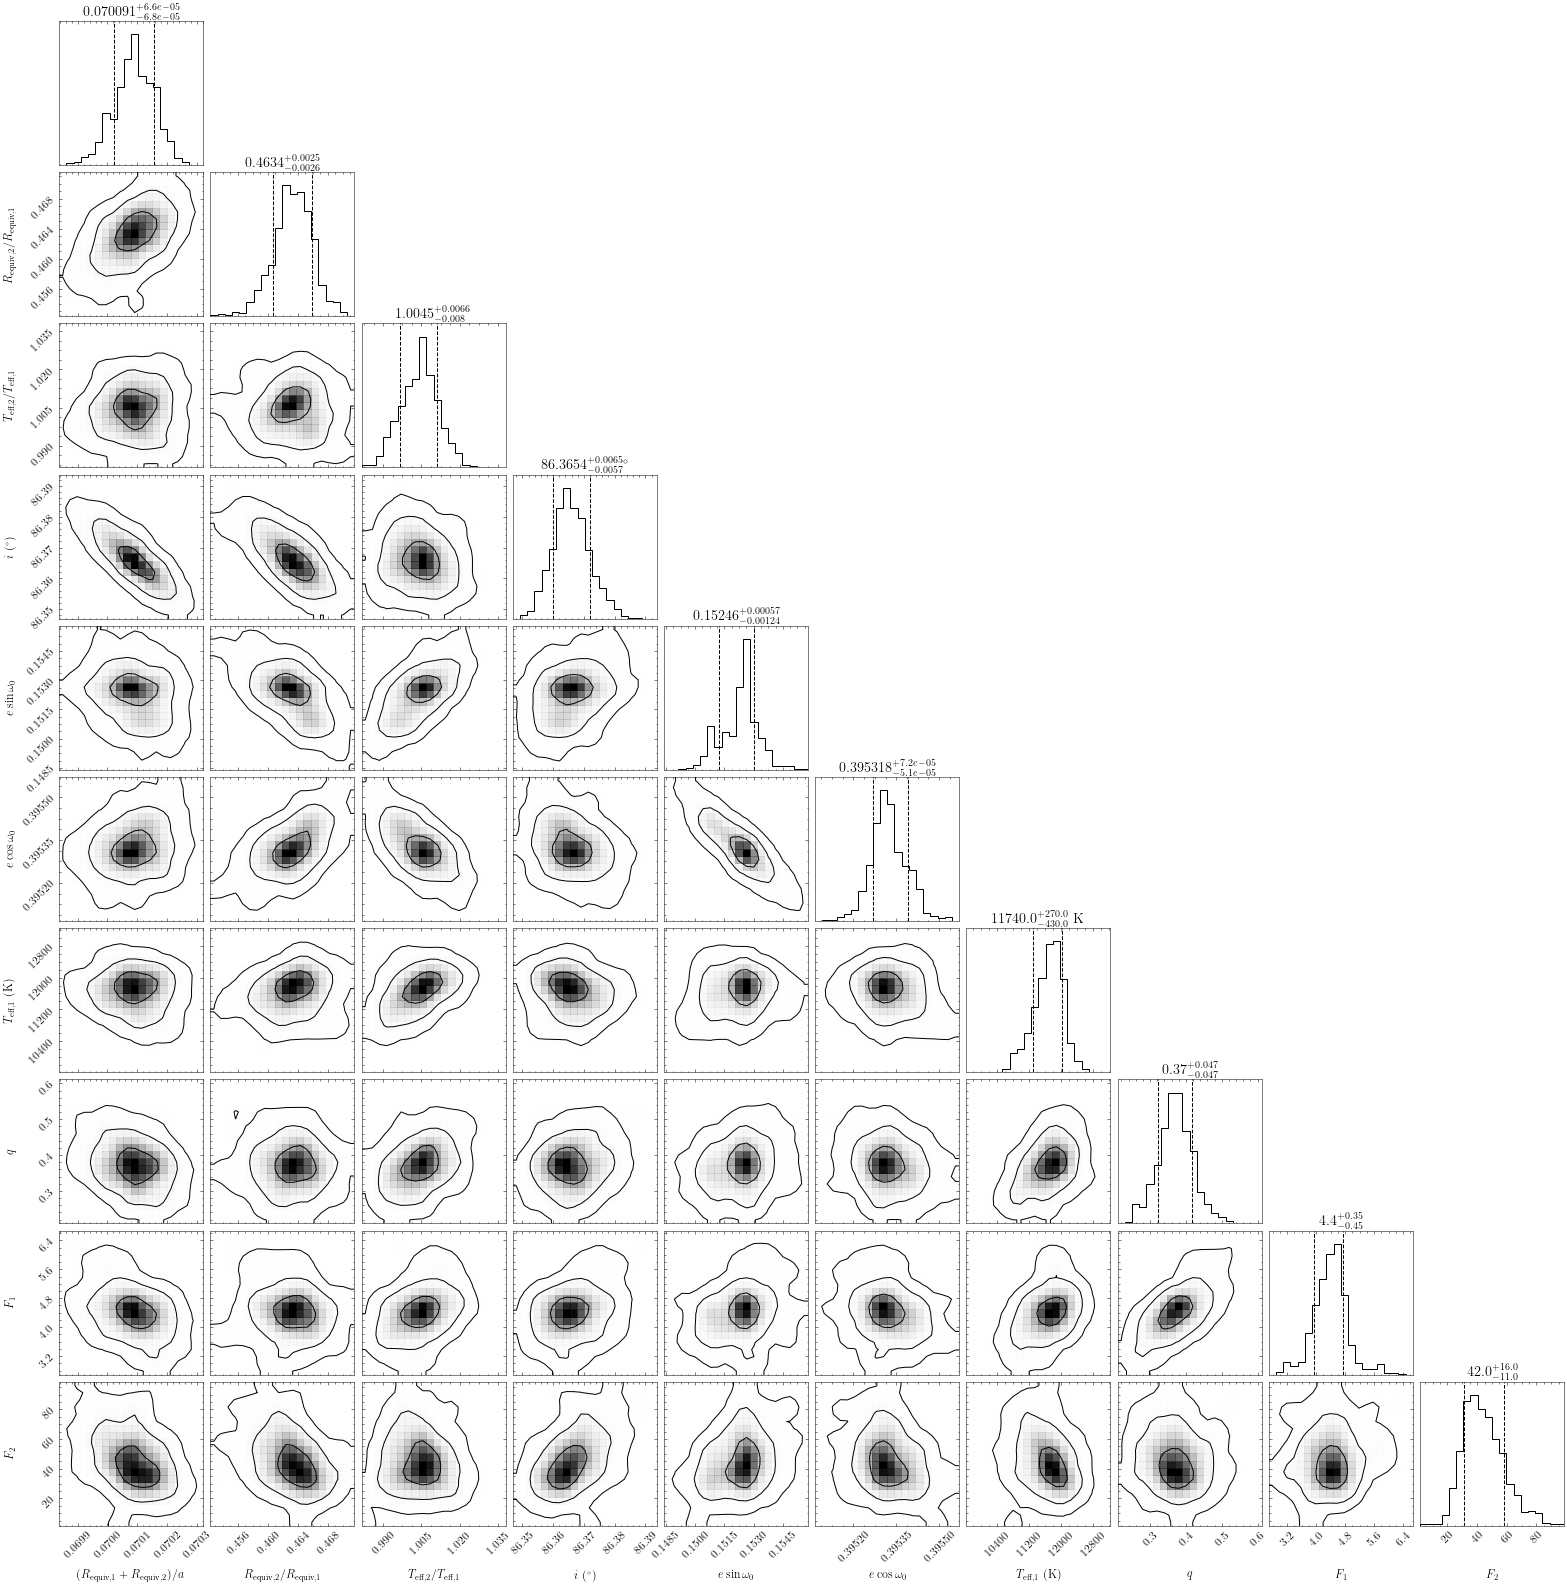

In [29]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 12

b.set_value('latex_repr', component='binary', value=' ')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

afig, mplfig = b.plot(style='corner', 
                      adopt_parameters=[
                          'requivsumfrac', 'requivratio', 
                                        'teffratio', 
                          'incl@binary','esinw', 'ecosw', 
                                        'teff@primary', 'q',
                                       'syncpar@primary', 'syncpar@secondary'],
#                       distributions_convert='mvgaussian',
                      solution='mcmc_r2', 
                      burnin=600, thin=1, 
                      lnprob_cutoff = 7400, rasterized=True,
                      show_titles=True, 
                      smooth=1, 
                      quantiles=[0.16, 0.5, 0.84], 
                      fill_contours=False, 
                      plot_datapoints=False);

In [30]:
mplfig.set_size_inches(15.28,15.28)

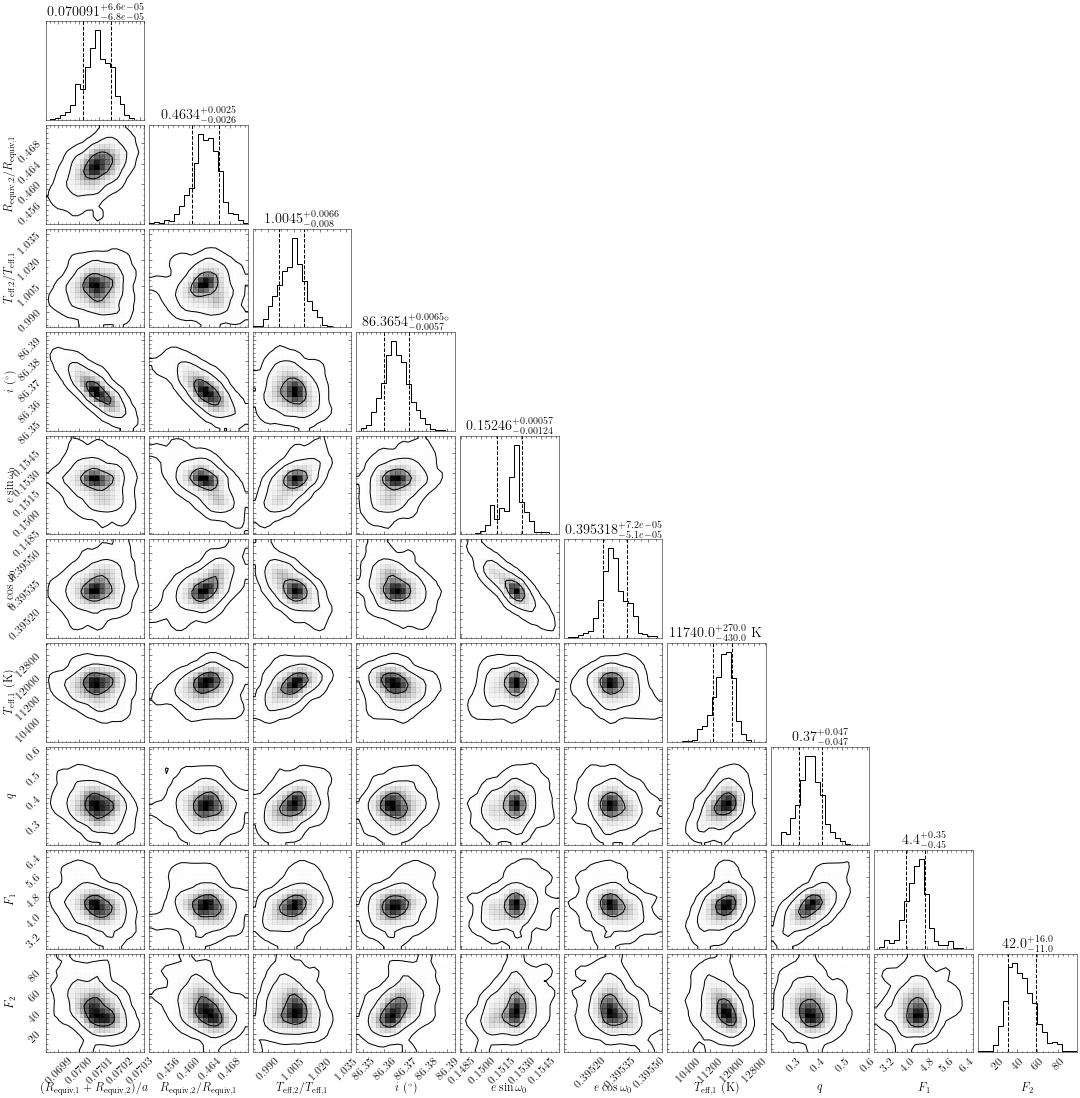

In [31]:
mplfig

In [32]:
mplfig.savefig('plots/corner_phoebe2.pdf', dpi=300, rasterized=True)

<ipython-input-32-614fc4617b38>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  mplfig.savefig('plots/corner_phoebe2.pdf', dpi=300, rasterized=True)
